In [2]:
from chromatic import *
import emcee
import corner
import speclite as speclite
import glob as glob
from speclite import filters
from tqdm import tqdm
from matplotlib import cm
from matplotlib.artist import Artist
from scipy.optimize import minimize
from scipy.optimize import curve_fit

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('tableau-colorblind10')

  0%|          | 0/1 [00:00<?, ?it/s]

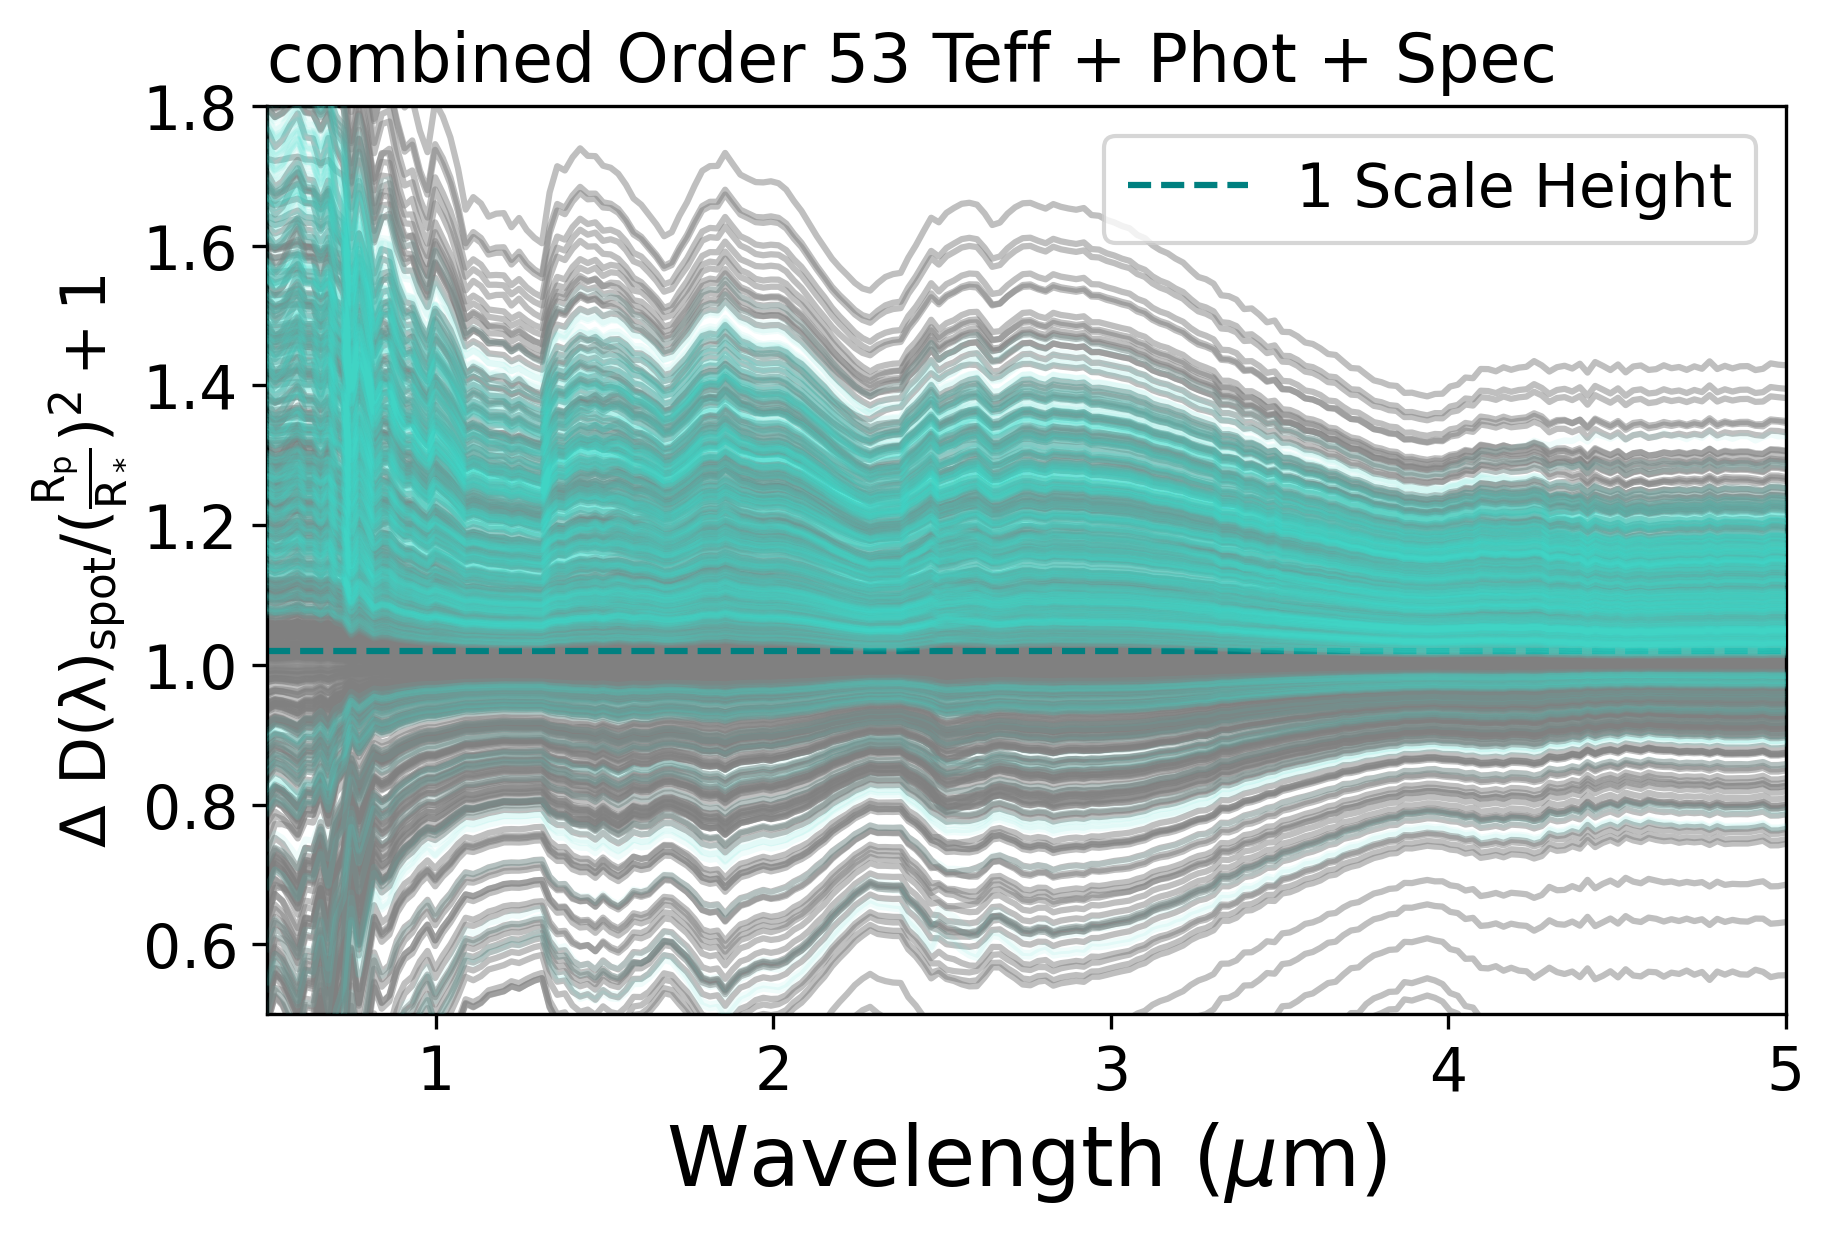

100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


In [34]:
ordernumbers = np.arange(53,84)
bad_orders = np.array([56,57,59,60,62,63,64,65,66,67,68,69,
                       72,73,74,75,78,79,80,83])
# good_orders = np.array([53,54,55,58,61,70,71,76,77,81,82])
good_orders = np.array([53])

# nsteps = 1000
# modeltype = 'Final_Teff_Phot'
# modelname = 'Teff + Phot'
# visits = ['F21','S22']
# orders_I_care_about = [52]

# nsteps = 1000
# modeltype = 'Final_Teff_Spec'
# modelname = 'Teff + Spec'
# visits = ['F21','S22','combined']
# orders_I_care_about = good_orders

# nsteps = 2000
# modeltype = f'Final_Teff_Phot_Spec'
# modelname = 'Teff + Phot + Spec'
# suptitle = r'T$_{\rm{eff}}$ & Photometric & S($\lambda$) Model Results'
# visits = ['F21','S22']
# orders_I_care_about = good_orders

nsteps = 3000
modeltype = f'Final_Teff_Phot_Spec'
modelname = 'Teff + Phot + Spec'
suptitle = r'T$_{\rm{eff}}$ & Photometric & S($\lambda$) Model Results'
visits = ['combined']
orders_I_care_about = good_orders

for visit in tqdm(visits):
                
    for order in orders_I_care_about:
        label = f'{visit}_{order}_{modeltype}'
        samples_file_label = label+f'_{nsteps}steps'
        '''
        READ IN THE MCMC SAMPLES
        '''
        reader = emcee.backends.HDFBackend(f'../data/samples/{samples_file_label}.h5')
        sampler = reader.get_chain(discard=int(0.25*nsteps), flat=True)
        samples = sampler.reshape((-1, 4)).T
        fspot_sam, dfspot_sam, Tspot_sam, Tamb_sam = samples

        variable_names = [r'f$_{\rm{spot}}$',r'$\Delta$f$_{\rm{spot}}$',r'T$_{\rm{spot}}$',r'T$_{\rm{amb}}$']
        normie_names = ['fspot','dfspot','Tspot','Tamb']        

        """
        Now we will plot samples from the posteriors
        """
        wavelength=np.linspace(0.5,5,200)*u.micron
        plt.figure(figsize=(6,4))
        title_label=f'{visit} Order {order} {modelname}'
        plt.title(title_label,fontsize=16,loc='left')        
        plt.ylabel(r'$\rm{\Delta~D(\lambda)_{spot}}/(\frac{R_p}{R_*})^2+1$',fontsize=15)
        plt.xlabel(r'Wavelength ($\mu$m)',fontsize=20)
        plt.ylim(0.5,1.8)
        plt.xlim(0.5,5)
        plt.axhline(1.02,color='teal',label='1 Scale Height',linestyle='--')
        # plt.axhline(1.0,color='k',label='Opaque transit depth')
        for k in range(0,500):
            j = np.random.randint(low=0,high=(len(Tspot_sam)-1))
            transit_depth = (0.0512)**2.
            s_spot = get_phoenix_photons(temperature=Tspot_sam[j], wavelength = wavelength,
                                                           logg=4.4, metallicity=0.0)
            s_amb = get_phoenix_photons(temperature=Tamb_sam[j], wavelength = wavelength,
                                                           logg=4.4, metallicity=0.0)
            flux_ratio = s_spot[1]/s_amb[1]
            top = 1.
            bottom = (1. - fspot_sam[j]) + fspot_sam[j] * flux_ratio
            delta_D_spot = ((top / bottom) - 1.) * transit_depth
            depth_factor = (delta_D_spot/transit_depth) + 1.
            
            rand_Tspot = np.random.uniform(2500.0, 4400.0)
            rand_fspot = np.random.uniform(0.01,0.5)
            rand_df = np.random.uniform(0.005,rand_fspot)
            # rand_Tamb = 3800.0
            rand_Tamb = ( (3700.0**4 - rand_fspot*rand_Tspot**4) / (1-rand_fspot) )**(1/4)
            
            if rand_Tamb <= 2300.0:
                rand_Tamb = 2301.0
            _s_spot = get_phoenix_photons(temperature=rand_Tspot, wavelength = wavelength,
                                                           logg=4.4, metallicity=0.0)
            _s_amb = get_phoenix_photons(temperature=rand_Tamb, wavelength = wavelength,
                                                           logg=4.4, metallicity=0.0)
            _flux_ratio = _s_spot[1]/_s_amb[1]
            _top = 1.
            _bottom = (1. - rand_fspot) + rand_fspot * _flux_ratio
            _delta_D_spot = ((_top / _bottom) - 1.) * transit_depth
            _depth_factor = (_delta_D_spot/transit_depth) + 1.
            
            plt.plot(s_spot[0],depth_factor,color = 'turquoise',alpha=0.08,zorder=100) # this will be the input wavelength from the order in question
            plt.plot(s_spot[0],_depth_factor,color = 'gray',alpha=0.5,zorder=-100) # this will be the input wavelength from the order in question
        plt.legend(loc = 'upper right')
        plt.savefig(f'../figs/{label}_contam.png',dpi=200)
        plt.show()
        plt.close()